In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns





CONNECTIVITY_MATRIX_SHAPE: (360, 1200)
BRAIN_REGION_INFO: (360, 12)
                          region region_abbrev hemi  region_idx  \
0          Primary Visual Cortex            V1    R           0   
1  Medial Superior Temporal Area           MST    R           1   
2              Sixth Visual Area            V6    R           2   
3             Second Visual Area            V2    R           3   
4              Third Visual Area            V3    R           4   

            network network_abbrev  network_idx  network_region_idx  \
0    Primary Visual           VIS1            1                   4   
1  Secondary Visual           VIS2            2                  97   
2  Secondary Visual           VIS2            2                  98   
3  Secondary Visual           VIS2            2                  99   
4  Secondary Visual           VIS2            2                 100   

  network_colour      mni_x      mni_y      mni_z  
0      royalblue -12.684422 -82.321608   1.542622 

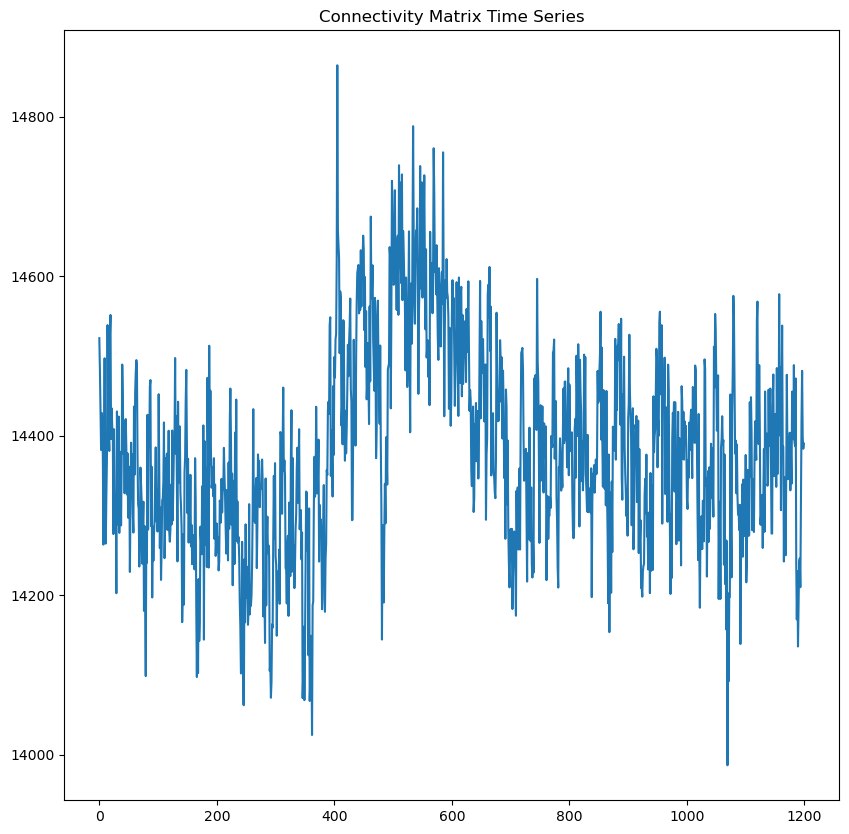

In [2]:
path_conn = '../data/hcp/raw/100206_0.npy'
path_brain_region = '../data/brain_regions.csv'

# Load the connectivity matrix
connectivity_matrix = np.load(path_conn)

# Load the brain regions
brain_regions = pd.read_csv(path_brain_region)

# Check the shape of your connectivity matrix
print("CONNECTIVITY_MATRIX_SHAPE:", connectivity_matrix.shape)
print("BRAIN_REGION_INFO:", brain_regions.shape)

# Check the first few rows of your brain regions data
print(brain_regions.head())

# Basic visualization of the connectivity matrix
# plt.figure(figsize=(10, 10))
# sns.heatmap(connectivity_matrix, cmap='viridis')
# plt.title('Connectivity Matrix')
# plt.show()

plt.figure(figsize=(10, 10))
plt.plot(connectivity_matrix[359])
plt.title('Connectivity Matrix Time Series')
plt.show()



SCAN_SHAPE:  (360, 490)
FC_MATRIX_SHAPE: (16, 360, 360)


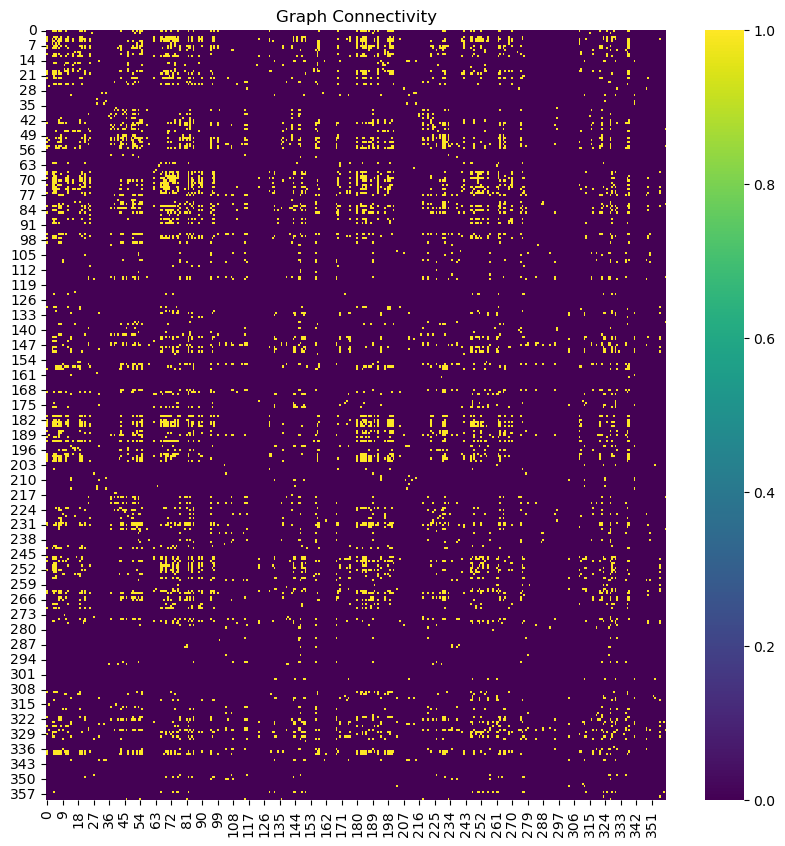

In [3]:
scan = np.load(path_conn)[:, :490]
print('SCAN_SHAPE: ', scan.shape)

def create_fc_matrices(scan, window_size=30, step_size=30):
    """
    Create functional connectivity matrices using a sliding window approach.
    """
    n_timepoints = scan.shape[1]
    fc_matrices = []

    for start in range(0, n_timepoints - window_size + 1, step_size):
        window = scan[:, start:start + window_size]
        correlation_matrix = np.corrcoef(window)
        fc_matrices.append(correlation_matrix)

    return fc_matrices

# Example of processing one scan
fc_matrices = create_fc_matrices(scan)
print('FC_MATRIX_SHAPE:', np.array(fc_matrices).shape)

def threshold_fc_matrix(fc_matrix, percentile=5):
    """
    Threshold the FC matrix to keep only the top percentile connections.
    """
    threshold = np.percentile(fc_matrix[np.tril_indices_from(fc_matrix, k=-1)], 100 - percentile)   
    graph = (fc_matrix > threshold).astype(int)
    np.fill_diagonal(graph, 0)  # remove self-edges
    return graph

# Example of thresholding one FC matrix
graphs = [threshold_fc_matrix(fc) for fc in fc_matrices]     # --> ho 16 grafi, per ogni time_window (30)

# Heatmap of one graph of 16
plt.figure(figsize=(10, 10))
sns.heatmap(graphs[0], cmap='viridis')
plt.title('Graph Connectivity')
plt.show()

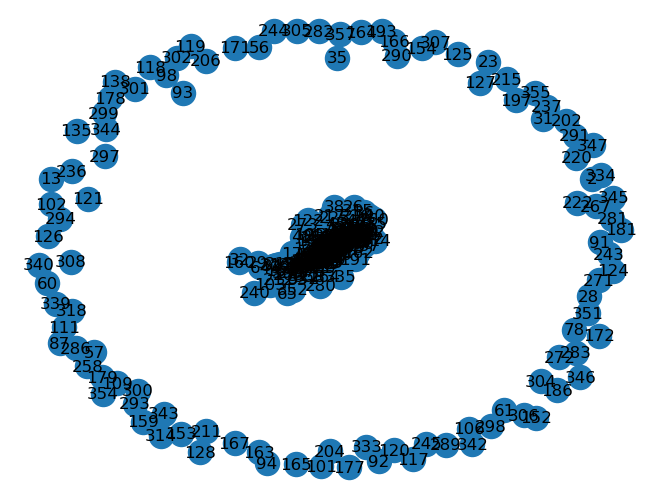

GRAPHS_SHAPE: (16, 360, 360)


In [15]:
import networkx as nx

def create_networkx_graph(matrix):
    G = nx.Graph(matrix)
    return G

# Visualize one graph using NetworkX
G = create_networkx_graph(graphs[0])
nx.draw(G, with_labels=True)
plt.show()
print("GRAPHS_SHAPE:" ,np.array(graphs).shape)

In [16]:
from torch_geometric.data import Data

def convert_to_pyg_graph(nx_graph):
    graph = nx.Graph(nx_graph)
    edges = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()
    x = torch.tensor(np.identity(graph.number_of_nodes()), dtype=torch.float)
    
    # For unsupervised learning, you typically don't have node labels
    # If you have node features, replace x with them
    return Data(x=x, edge_index=edges)

In [17]:
pyg_graphs = [convert_to_pyg_graph(g) for g in graphs]

for i in range(len(pyg_graphs)):
    print(pyg_graphs[i])

# --> every region can be connected to the 5% of nodes, (((N-1) * N)/2) * 5/100

Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])


### Classification GNN's (Alex paper)

In [4]:
def temporal_splitting_stack(X, P, S):
    """
    Apply temporal-splitting stack transformation to input BOLD signals.
    The purpose of this transformation is to split the original BOLD signal into overlapping windows, each capturing a local temporal pattern.

    Parameters:
    - X: BOLD signals of shape (T', V) where T' is the number of time points and V is the number of brain regions.
    - P: Window length (hyperparameter).
    - S: Stride (hyperparameter).

    Returns:
    - X_tilde: Transformed data of shape (P, V, T) representing the stacked windows.
    """
    T_prime, V = X.shape
    T = int(np.floor((T_prime - 2 * (P - 1) - 1) / S) + 1)
    X_tilde = np.zeros((P, V, T))

    for t in range(T):
        start_idx = t * S
        end_idx = start_idx + P
        X_tilde[:, :, t] = X[start_idx:end_idx, :]

    return X_tilde

X1_T_prime = connectivity_matrix.T
P = 30  # Window length
S = 1  # Stride
X_tilde = temporal_splitting_stack(X1_T_prime, P, S)


In [5]:
print("X_TILDE SHAPE: ", X_tilde.shape)
print("NEW T: ", (X1_T_prime.shape[0]-(2*(P-1))-1)+1)

(30, 360, 1142)
1142


In [6]:
class InceptionTCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels_list, kernel_sizes_list, dilation_factors_list):
        super(InceptionTCNLayer, self).__init__()
        self.branches = nn.ModuleList()

        # Check --> out_channels_list, kernel_sizes_list, and dilation_factors_list are lists
        if not isinstance(out_channels_list, list):
            out_channels_list = [out_channels_list]
        if not isinstance(kernel_sizes_list, list):
            kernel_sizes_list = [kernel_sizes_list]
        if not isinstance(dilation_factors_list, list):
            dilation_factors_list = [dilation_factors_list]
        for i in range(len(out_channels_list)):
            branch = nn.Conv2d(in_channels, out_channels_list[i], kernel_size=(1, kernel_sizes_list[i]), dilation=(1, dilation_factors_list[i]), padding=(0, dilation_factors_list[i]))
            self.branches.append(branch)

    def forward(self, x):
        # Apply each branch and concatenate along the feature dimension
        branch_outputs = [branch(x) for branch in self.branches]
        x = torch.cat(branch_outputs, dim=0)
        return x

class ITCNModel(nn.Module):
    def __init__(self, KE, V, T, num_layers, num_filters_list, kernel_sizes_list, dilation_factors_list):
        super(ITCNModel, self).__init__()
        self.feature_layers = nn.ModuleList()

        for i in range(num_layers):
            in_channels = 1 if i == 0 else num_filters_list[i-1]
            out_channels_list = num_filters_list[i]
            kernel_sizes_list_i = kernel_sizes_list[i]
            dilation_factors_list_i = dilation_factors_list[i]
            layer = InceptionTCNLayer(in_channels, out_channels_list, kernel_sizes_list_i, dilation_factors_list_i)
            self.feature_layers.append(layer)

        # Output layer
        self.output_layer = nn.Conv2d(num_filters_list[-1], KE, kernel_size=(1, 1))

    def forward(self, x):
        for layer in self.feature_layers:
            x = F.relu(layer(x))
        x = self.output_layer(x)
        return x

V, T = 360, 1142 
# Define hyperparameters
KE = 64
num_layers = 3
num_filters_list = [4, 8, 16]  # Number of filters for each layer
kernel_sizes_list = [[3], [5], [7]]  # Kernel sizes for each layer
dilation_factors_list = [[1], [2], [4]]  # d = 2^(l−1)

X_tilde_reshaped = np.array(X_tilde).reshape((30, 1, V, T))   # reshape for first channel = 1
X_tilde_reshaped = torch.Tensor(X_tilde_reshaped)

itcn_model = ITCNModel(KE, V, T, num_layers, num_filters_list, kernel_sizes_list, dilation_factors_list)
itcn_output = itcn_model(X_tilde_reshaped)

print(itcn_output.shape)  


torch.Size([30, 64, 360, 1122])


In [ ]:
# why 1122 =/ 1142 --> depends on dilation_factors --> padding?
# how to handle the window component (30)